<a href="https://colab.research.google.com/github/ykato27/SHAP_NLP/blob/main/SHAP_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# datasetsから取得したデータセットをtsv形式で一旦保存したいので、保存先としてGoogle Driveをするためにマウントしてます。
# colabにGoogle Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 必要なライブラリをpipでインストール
!pip install shap # SHAPはpipで簡単にインストールできます
!pip install datasets
!pip install transformers

     |████████████████████████████████| 358kB 10.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=ef7a04fd6dc3f167c3edb267bc491c15c19f597e2625985d551af46725d958c8
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 194kB 10.7MB/s 
     |████████████████████████████████| 112kB 10.7MB/s 
     |████████████████████████████████| 245kB 15.5MB/s 
     |████████████████████████████████| 1.9MB 10.9MB/s 
     |████████████████████████████████| 890kB 37.8MB/s 
     |████████████████████████████████| 3.2MB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=98f4ade8e2435a26741811d1e0022bc78d11b22342a6f0a4f23314b3b01b0940
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import shap
import datasets
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import scipy as sp
import random
from IPython.display import display, HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from transformers import BertModel
from transformers import BertTokenizer

# データセット格納先
drive_dir = "drive/MyDrive/SHAP_NLP/"

In [4]:
# cased->大文字と小文字を区別しない
# uncased->大文字と小文字を区別する
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained("bert-base-cased")

In [5]:
emotion_dataset = datasets.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6. Subsequent calls will reuse this data.


In [6]:
# まずはDataFrameに変換
# 学習データ
train_df = pd.DataFrame(emotion_dataset['train']['text'], columns=['text'])
train_df['label'] = emotion_dataset['train']['label']
# テストデータ
test_df = pd.DataFrame(emotion_dataset['test']['text'], columns=['text'])
test_df['label'] = emotion_dataset['test']['label']

# tsvファイルとして保存。保存先はマウントしたGoogle Drive
train_df.to_csv(drive_dir + 'train.tsv', sep='\t', index=False, header=None)
test_df.to_csv(drive_dir + 'test.tsv', sep='\t', index=False, header=None)

# 正解ラベルの数
# emotion datasetのラベルの数は6つです。
LABEL_NUM = len(set(train_df['label'])) 
# LABEL_NUM = 6

# ちなみに各ラベルの意味は以下の通りです。
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# 後ほど使うので、ラベルIDをラベルに変換、ラベルをラベルIDに変換する辞書をそれぞれ作成しておきます。
id2label = {i:labels[i] for i in range(len(labels))}
label2id = {label:labels.index(label) for label in labels}

In [7]:
# 英語版のBERTはtokenizerのoutputが辞書形式で返却されるようで
# 分かち書きのtoken idのリストは'input_ids'キーに格納されています。
# BERT modelの引数に対応した形のようです。
# Reference: https://huggingface.co/transformers/model_doc/bert.html
print(tokenizer(train_df['text'][0]))
# {'input_ids': [101, 178, 1238, 1204, 1631, 21820, 21896, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

def encode(text):
    return tokenizer(text)['input_ids']

TEXT = torchtext.data.Field(sequential=True, tokenize=encode, use_vocab=False, lower=False, include_lengths=True, batch_first=True, pad_token=0)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

train_data, test_data = torchtext.data.TabularDataset.splits(path=drive_dir, train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL)])

BATCH_SIZE = 32
train_iter, test_iter = torchtext.data.Iterator.splits((train_data, test_data), batch_sizes=(BATCH_SIZE, BATCH_SIZE), repeat=False, sort=False)

{'input_ids': [101, 178, 1238, 1204, 1631, 21820, 21896, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
class BertClassifier(nn.Module):
  def __init__(self, base_model, label_num):
    super(BertClassifier, self).__init__()
    self.bert = base_model
    # BERTのアウトプットの次元数は768次元、label_numは正解ラベルの数を指定する
    self.linear = nn.Linear(768, label_num) 

    # 重み初期化処理
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, encode_input):
    # Attentionの可視化も行いたいので、output_attentions=Trueを指定してます。
    output = self.bert(encode_input, output_attentions=True)

    # outputが辞書形式になっているので、必要な出力のキーを指定して取得する
    vec = output['last_hidden_state']
    attentions = output['attentions']

    # 先頭トークンCLSのベクトルだけ取得
    vec = vec[:,0,:]
    vec = vec.view(-1, 768)

    # 全結合層でクラス分類用に次元を変換
    vec = self.linear(vec)

    return F.log_softmax(vec, dim=1), attentions

classifier = BertClassifier(base_model=model, label_num=LABEL_NUM)

In [9]:
# まずは全パラメータを学習対象外にする
for param in classifier.parameters():
    param.requires_grad = False

# BERTモデルの最後の層を学習対象
for param in classifier.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 最後の全結合層を学習対象
for param in classifier.linear.parameters():
    param.requires_grad = True

# 最適化関数、損失関数の定義
optimizer = optim.Adam([
    {'params': classifier.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': classifier.linear.parameters(), 'lr': 1e-4}
])

loss_function = nn.NLLLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

5エポックだけ学習

In [10]:
for epoch in range(5):
  all_loss = 0
  for idx, batch in enumerate(train_iter):
    batch_loss = 0
    classifier.zero_grad()
    input_ids = batch.Text[0].to(device)
    label_ids = batch.Label.to(device)
    out, _ = classifier(input_ids)
    batch_loss = loss_function(out, label_ids)
    batch_loss.backward()
    optimizer.step()
    all_loss += batch_loss.item()
  print("epoch", epoch, "\t" , "loss", all_loss)

epoch 0 	 loss 444.18480445444584
epoch 1 	 loss 191.23112715780735
epoch 2 	 loss 132.6342229731381
epoch 3 	 loss 89.50549877993762
epoch 4 	 loss 59.43214026791975


F1-scoreで精度を確認

In [11]:
answer = []
prediction = []
with torch.no_grad():
    for batch in test_iter:

        text_tensor = batch.Text[0].to(device)
        label_tensor = batch.Label.to(device)

        score, _ = classifier(text_tensor)
        _, pred = torch.max(score, 1)

        prediction += list(pred.cpu().numpy())
        answer += list(label_tensor.cpu().numpy())
print(classification_report(prediction, answer, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.93      0.91      0.92       592
         joy       0.92      0.89      0.90       716
        love       0.75      0.77      0.76       154
       anger       0.84      0.91      0.87       252
        fear       0.84      0.83      0.83       227
    surprise       0.62      0.69      0.66        59

    accuracy                           0.88      2000
   macro avg       0.82      0.84      0.82      2000
weighted avg       0.88      0.88      0.88      2000



#### SHAPを使ってモデルを解釈

In [12]:
# shap.Explainerの引数modelに指定する関数を以下で定義
# 引数のsentencesは自然文の配列を想定しています。
# 自然文が1つだけの時はその文章を配列に変換してから使います。
# max_lengthはテストデータの最大長さを指定しています。
def f(sentences):
    input_ids = torch.tensor([tokenizer.encode(text, padding='max_length', max_length=68) for text in sentences]).to(device)
    with torch.no_grad():
        out, _ = classifier(input_ids)
    return out.detach().cpu()

# SHAP値を計算するインスタンスを生成する
explainer = shap.Explainer(model=f, masker=tokenizer, output_names=labels)

# あとはSHAP値を計算したい自然文の配列をexplainerに渡せばOK
# 後ほど実行するのでここではコメントアウトしますが、以下のように自然文をインプットすればOK
# shap_values = explainer(sentences)

#### Attentionとの比較も行いたいので諸々用意

In [13]:
# SHAP値を算出するときと同様の方法でAttentionの結果を得られる関数を用意しておく
def f_a(sentences):
    input_ids = torch.tensor([tokenizer.encode(text, padding='max_length', max_length=68) for text in sentences]).to(device)
    with torch.no_grad():
        _, attn = classifier(input_ids)
    return input_ids[0].detach().cpu(), attn[-1].detach().cpu()

# 以下2つの関数はAttentionの結果を単語にハイライトするためのものです。
# 以前書いた記事で使っていた関数を今回用に書き換えています。
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(input_ids, attention_weight):
    # 文章の長さ分のzero tensorを宣言
    seq_len = attention_weight.size()[2]
    all_attens = torch.zeros(seq_len)

    # 12個のMulti Head Attentionの結果を全部足し合わせる
    # 最初の0はinput_idsは１文章だけを想定しているため
    # 次の0はCLSトークンのAttention結果を取得している、という意味です。
    for i in range(12):
        all_attens += attention_weight[0, i, 0, :]

    html = ""
    for word, attn in zip(input_ids, all_attens):
        if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
            break
        html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attn) + " "

    return html

#### 1つの文章に対して使ってみる

In [16]:
idx = random.randint(0,len(test_df))
sentence = test_df['text'][idx]
answer = id2label[test_df['label'][idx]]
predict = id2label[f([sentence]).argmax().item()]

# Attentionの計算
input_ids, attention = f_a([sentence])

print("元文章", sentence)
print("正解ラベル", answer)
print("予測ラベル", predict)
# 元文章 i dont know if i should let go and feel that vain or should i wait and stay in vain
# 正解ラベル sadness
# 予測ラベル sadness

# SHAP値を計算する
# sentenceは１文章だけなので、[]で囲って配列として渡してます。
shap_values = explainer([sentence])

元文章 i see the look of doubt on your face i feel the scorn in your eyes but for anyone skeptical of grits dinner grits please see this as a totally amazing sister to mashed potatoes
正解ラベル fear
予測ラベル joy


shap.plots.textに計算されたSHAP値を以下のように渡します。

In [17]:
# Attention可視化
print("■Attentionの可視化結果")
html_output = mk_html(input_ids, attention)
display(HTML(html_output))
print()

print("■SHAPの可視化結果")
# shap.plots.textに計算したSHAP値を渡します。
# どの単語や句が予測ラベルにどれくらい（プラスの方向、マイナスの方向に）効いていたかを可視化します。
# 赤がプラス、青がマイナスの方向を表現しており、濃淡は度合いを表しています。
shap.plots.text(shap_values[0,:,predict])

■Attentionの可視化結果



■SHAPの可視化結果


全ラベルに対して、各単語や句がどのラベルに効いていたかをHeat map形式でみる

In [18]:
shap.plots.text(shap_values[0,:,])

,,i see the look of doubt on your,face i feel the scorn in your eyes,but for anyone skeptical of grits dinner grits please see,this as a totally amazing sister to mashed potatoes,
sadness,0.0,-1.225,-1.637,-2.44,0.013,0.0
joy,-0.0,0.284,0.28,-0.291,-0.144,-0.0
love,0.0,-0.633,-0.595,2.97,0.747,0.0
anger,0.0,-0.384,-0.572,1.072,-0.788,0.0
fear,0.0,-1.657,-1.531,1.944,-0.284,0.0
surprise,0.0,-0.608,-0.373,0.39,1.382,0.0


shap.plots.barを使って棒グラフで可視化

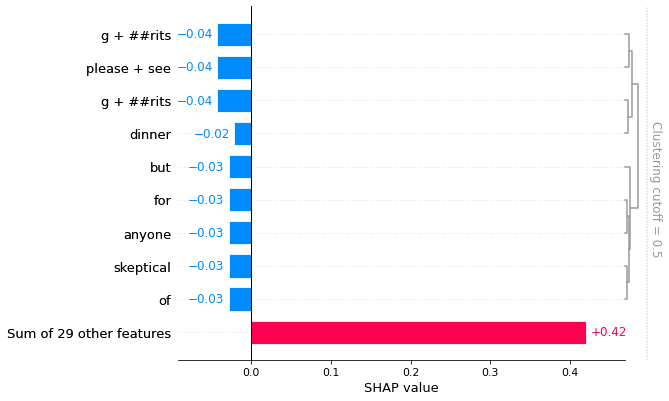

In [19]:
shap.plots.bar(shap_values[0,:,predict])

#### 複数文章に対して適用

In [20]:
# 予測が正しかった文章のみを抽出したいので、テストデータの各文章に対して予測ラベルを付与しておく
predict_list = []
for i in range(0, len(test_df), 10):
    _s = test_df['text'][i:i+10]
    predict_list += f(_s).argmax(dim=1).tolist()
test_df['pred'] = predict_list
# ちなみにこの予測結果と上でF1-scoreを算出したときの結果は微妙に異なります。
# 上で算出したときはpaddingはtorchtextが行った結果を使っており、ミニバッチ毎のmax_lengthでpaddingされていたかと思いますが、
# こちらで算出した結果は、全文章に対してmax_length 128でpaddingして（全文章の長さがpadding込みで128になって）おり、
# classifierに通すデータが異なっているのが原因と思われます。
# とりあえず細かいことは気にしない精神で実装してます、ご容赦いただけたらと思います。。。

loveと予測した文章全てのSHAP値を計算

In [21]:
target_label = "love"
label_id = label2id[target_label]
sentences = test_df.query('pred == @label_id')['text']

# ぼちぼち時間かかります。
shap_values = explainer(sentences)

Partition explainer: 162it [01:54,  1.41it/s]


SHAP値の高い順番に可視化

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


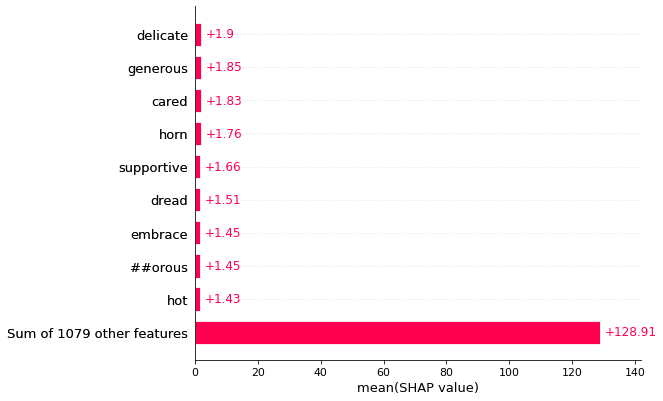

In [22]:
shap.plots.bar(shap_values[:,:,'love'].mean(0), max_display=10)

angerでも試してみます。

Partition explainer: 254it [02:59,  1.41it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


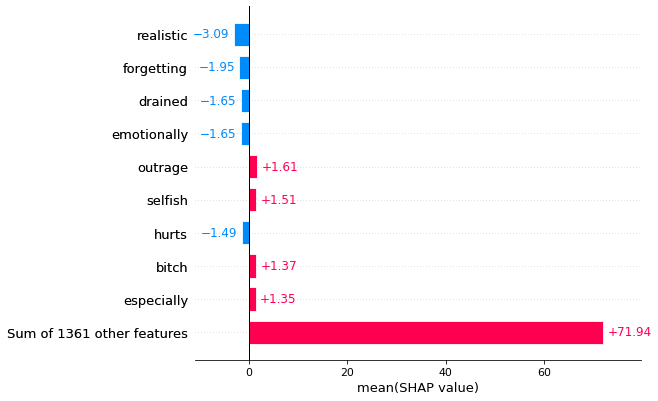

In [23]:
target_label = "anger"
label_id = label2id[target_label]
sentences = test_df.query('pred == @label_id')['text']

shap_values = explainer(sentences)

# SHAP値の高い順番に可視化してみる。
shap.plots.bar(shap_values[:,:,'anger'].mean(0), max_display=10)